# Notebook for learning from data coursework 2022

In [62]:
# import our libraries that we will be using to investigate the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## load out csv data into a pandas dataframe so that we can manipulate it

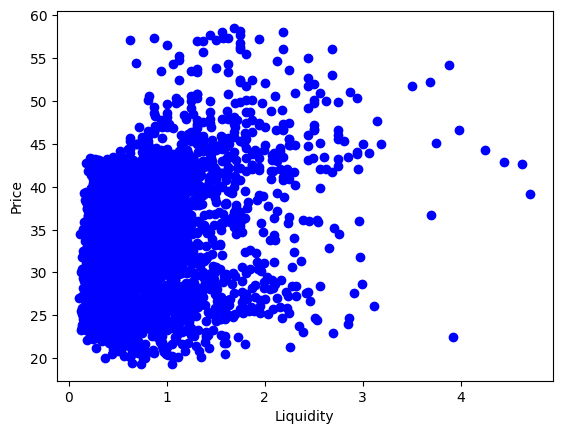

PearsonRResult(statistic=0.32620102308081855, pvalue=2.5876005955722507e-131)


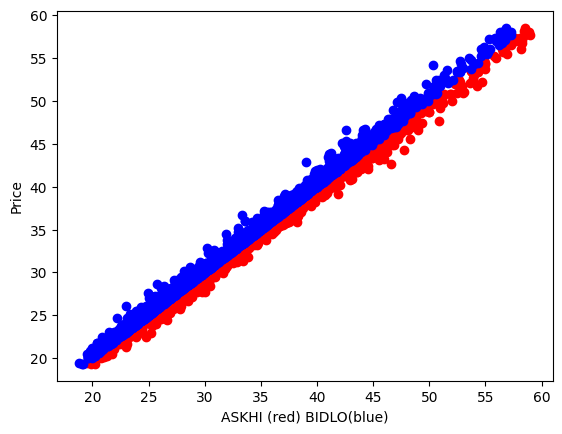

In [63]:
dataframe = pd.read_csv("AT_T_SBC_Stock_Price_Data_2000_2020.csv")

# filter out the columns we dont care about
dataframe["LIQ"] = dataframe["ASKHI"] - dataframe["BIDLO"]
important_cols = ["DATE", "OPENPRC", "VOL", "BIDLO", "ASKHI", "PRC", "LIQ"]
cols_to_include = ["PRC", "VOL"]
dataframe = dataframe[important_cols]

plt.plot(dataframe["LIQ"], dataframe["PRC"], "bo")
plt.xlabel("Liquidity")
plt.ylabel("Price")
plt.show()
print(pearsonr(dataframe["LIQ"], dataframe["PRC"]))

plt.plot(dataframe["ASKHI"], dataframe["PRC"], "ro")
plt.plot(dataframe["BIDLO"], dataframe["PRC"], "bo")
plt.xlabel("ASKHI (red) BIDLO(blue)")
plt.ylabel("Price")
plt.show()


In [64]:
def gen_model(model, data, cols, time_series_past, time_series_future, polynomial=0, show_plot=False):
    
    data = data.copy()

    #col_selection = cols_to_include.copy()
    col_selection = ["DATE"]
    for i in range(1, time_series_past):
        for col in cols:
            data[col + str(i) + "DAY"] = data[col].shift(periods=i)
            col_selection.append(col + str(i) + "DAY")

    data["PRC" + str(time_series_future) + "DAY"] = data["PRC"].shift(-time_series_future)

    if time_series_future == 0:
        cleaned_data = data.iloc[time_series_past:]
    else:
        cleaned_data = data.iloc[time_series_past:-time_series_future]

    if not polynomial == 0:
        poly = PolynomialFeatures(degree=polynomial, include_bias=False)
        poly.fit_transform(cleaned_data[cols])
        features = poly.transform(cleaned_data[cols])
        headers = poly.get_feature_names(cleaned_data[cols])
        X = features
    else:
        X = cleaned_data[col_selection]
    if time_series_future == 0:
        Y = cleaned_data["PRC"]
    else:
        Y = cleaned_data["PRC" + str(time_series_future) + "DAY"]

    #x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    #model.fit(x_train, y_train)

    # predict our testing data
    #predictions = model.predict(x_test)
    predictions = cross_val_predict(model, X, Y)
    print(len(predictions))

    total_error = 0

    # itterate our predictions and calculate the mean square error
    for i in range(len(predictions) - 1):
        total_error += pow(predictions[i] - Y.array[i], 2)

    if show_plot:
        print("number of predictions:", len(Y))

        if polynomial == 0:
            plt.plot(X["DATE"], predictions, "bo", markersize=0.3)
            plt.plot(X["DATE"], Y, "r-", linewidth=0.45)
        else:
            plt.plot(X.transpose()[0], predictions, "bo", markersize=0.3)
            plt.plot(X.transpose()[0], Y, "r-", linewidth=0.45)
        plt.title(str(model) + " predicting " + str(time_series_future) + " days into the future")
        plt.show()

    # check our mean square error for our models
    MSE = total_error / len(Y)
    print("total error squared: ", total_error, "MSE:", MSE)

    cross_val_linear = cross_val_score(model, X, Y)
    print("cross validation score:", cross_val_linear)

    return MSE

## take a look at the results when we include all the important data

In [65]:
linear_all_props = gen_model(LinearRegression(), dataframe, important_cols, time_series_past=5, time_series_future=0)
lasso_all_props = gen_model(Lasso(max_iter=3000), dataframe, important_cols, time_series_past=5, time_series_future=0)
ridge_all_props = gen_model(Ridge(max_iter=3000), dataframe, important_cols, time_series_past=5, time_series_future=0)

5282
total error squared:  1655.843987872449 MSE: 0.31348807040371995
cross validation score: [0.99209734 0.996042   0.97715208 0.9811265  0.98390535]
5282
total error squared:  2114.4619297524473 MSE: 0.4003146402409026
cross validation score: [0.98867038 0.99491149 0.97466178 0.97936428 0.98365172]
5282
total error squared:  1655.722753864296 MSE: 0.3134651181113775
cross validation score: [0.99209815 0.99604211 0.97715268 0.98112851 0.98390598]


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.25591e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.36042e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.5099e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.16217e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear

## check if reducing the amount of data will change our prediction quality

In [66]:
linear_selected_props = gen_model(LinearRegression(), dataframe, cols_to_include, time_series_past=5, time_series_future=0)
lasso_selected_props = gen_model(Lasso(max_iter=3000), dataframe, cols_to_include, time_series_past=5, time_series_future=0)
ridge_selected_props = gen_model(Ridge(max_iter=3000), dataframe, cols_to_include, time_series_past=5, time_series_future=0)

5282
total error squared:  1663.2667695812167 MSE: 0.3148933679631232
cross validation score: [0.99205734 0.99610489 0.97683128 0.98116368 0.98373011]
5282
total error squared:  2117.121953681884 MSE: 0.40081824189357895
cross validation score: [0.98864764 0.99491141 0.97464539 0.9793397  0.98365702]
5282
total error squared:  1663.3361659884267 MSE: 0.3149065062454424
cross validation score: [0.99205656 0.99610507 0.97683148 0.98116473 0.98372994]


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.19817e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.00131e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.20438e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.97356e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linea

## selected columns with regularisation

In [67]:
linear_selected_props_normal = gen_model(LinearRegression(), dataframe, important_cols, time_series_past=5, time_series_future=10)
lasso_selected_props_normal = gen_model(Lasso(max_iter=3000, normalize=True), dataframe, important_cols, time_series_past=5, time_series_future=10)
ridge_selected_props_normal = gen_model(Ridge(max_iter=3000, normalize=True), dataframe, important_cols, time_series_past=5, time_series_future=10)

5272
total error squared:  14019.365393140282 MSE: 2.659211948622967
cross validation score: [0.93436674 0.96403149 0.82684457 0.82719479 0.85465384]
5272
total error squared:  253064.75764736228 MSE: 48.00166116224626
cross validation score: [-0.07668316 -0.1799334  -3.32858484 -2.05422081 -0.25033852]
5272
total error squared:  16630.688673652257 MSE: 3.154531235518258
cross validation score: [0.92190217 0.95366804 0.79181306 0.78547501 0.84348895]


## can we predict more into the future than one day?

5272
total error squared:  14019.365393140282 MSE: 2.659211948622967
cross validation score: [0.93436674 0.96403149 0.82684457 0.82719479 0.85465384]
5272
total error squared:  14647.129559774792 MSE: 2.7782870940392246
cross validation score: [0.92993753 0.96190646 0.82166076 0.82201095 0.85620994]
5272
total error squared:  14018.592890553364 MSE: 2.6590654193007137
cross validation score: [0.93436861 0.96403326 0.8268444  0.82718968 0.85468354]
5272
total error squared:  14007.03663803151 MSE: 2.6568734138906507


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.2862e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.38898e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.54445e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.1895e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_

cross validation score: [0.93456197 0.96331428 0.82527616 0.82628976 0.85720716]
5272
total error squared:  14636.734590913975 MSE: 2.7763153624647146
cross validation score: [0.93037948 0.96155431 0.8197708  0.82006375 0.85677076]
5272
total error squared:  14006.62297329329 MSE: 2.656794949410715
cross validation score: [0.93456754 0.96331418 0.82528558 0.82627924 0.85719536]
5272
number of predictions: 5272


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.2093e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.02597e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.23523e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.99569e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear

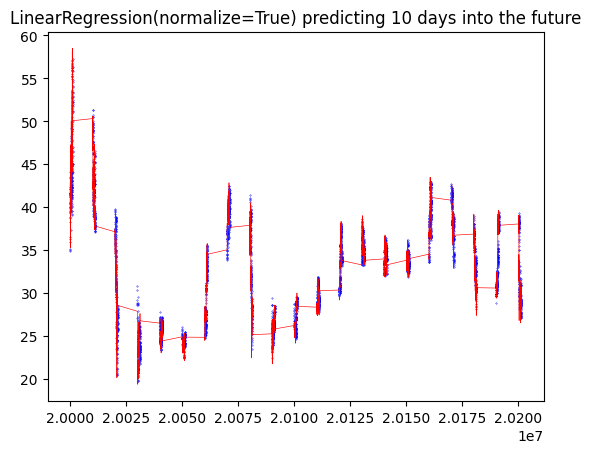

total error squared:  14007.036639043721 MSE: 2.656873414082648
cross validation score: [0.93456197 0.96331428 0.82527616 0.82628976 0.85720716]
5272
total error squared:  253064.75764736228 MSE: 48.00166116224626
cross validation score: [-0.07668316 -0.1799334  -3.32858484 -2.05422081 -0.25033852]
5272
total error squared:  18763.470408591966 MSE: 3.5590801230257902
cross validation score: [0.91392869 0.93997574 0.7492302  0.75241006 0.84208637]


In [68]:
# 10 days into the future
linear_10_days_all = gen_model(LinearRegression(), dataframe, important_cols, time_series_past=5, time_series_future=10)
lasso_10_days_all = gen_model(Lasso(max_iter=3000), dataframe, important_cols, time_series_past=5, time_series_future=10)
ridge_10_days_all = gen_model(Ridge(max_iter=3000), dataframe, important_cols, time_series_past=5, time_series_future=10)

linear_10_days = gen_model(LinearRegression(), dataframe, cols_to_include, time_series_past=5, time_series_future=10)
lasso_10_days = gen_model(Lasso(max_iter=3000), dataframe, cols_to_include, time_series_past=5, time_series_future=10)
ridge_10_days = gen_model(Ridge(max_iter=3000), dataframe, cols_to_include, time_series_past=5, time_series_future=10)

linear_10_days_normal = gen_model(LinearRegression(normalize=True), dataframe, cols_to_include, time_series_past=5, time_series_future=10, show_plot=True)
lasso_10_days_normal = gen_model(Lasso(max_iter=3000, normalize=True), dataframe, cols_to_include, time_series_past=5, time_series_future=10)
ridge_10_days_normal = gen_model(Ridge(max_iter=3000, normalize=True), dataframe, cols_to_include, time_series_past=5, time_series_future=10)

## investigate ridge regression

In [69]:
ridge_100_days = gen_model(Ridge(max_iter=3000), dataframe, cols_to_include, time_series_past=5, time_series_future=100)

5182
total error squared:  89856.69536895439 MSE: 17.340157346382554
cross validation score: [ 0.65440219  0.71537438 -0.16539509 -0.32851452 -0.05918522]


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.23341e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.12034e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.32166e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.12044e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/alex/.local/lib/python3.10/site-packages/sklearn/linea

## using only the price of the previous dates

In [70]:
linear_100_days_5_past = gen_model(LinearRegression(normalize=True), dataframe, cols_to_include, time_series_past=5, time_series_future=100)
lasso_100_days_5_past = gen_model(Lasso(max_iter=3000), dataframe, cols_to_include, time_series_past=5, time_series_future=100)
ridge_100_days_5_past = gen_model(Ridge(max_iter=3000, normalize=True), dataframe, cols_to_include, time_series_past=5, time_series_future=100)
linear_100_days_14_past = gen_model(LinearRegression(normalize=True), dataframe, cols_to_include, time_series_past=14, time_series_future=100)
lasso_100_days_14_past = gen_model(Lasso(max_iter=3000), dataframe, cols_to_include, time_series_past=14, time_series_future=100)
ridge_100_days_14_past = gen_model(Ridge(max_iter=3000, normalize=True), dataframe, cols_to_include, time_series_past=14, time_series_future=100)

5182
total error squared:  89902.36083254544 MSE: 17.348969670502786
cross validation score: [ 0.65396065  0.71538836 -0.16535452 -0.32844106 -0.05916315]
5182
total error squared:  87582.551713826 MSE: 16.901302916600926
cross validation score: [ 0.67612611  0.71130079 -0.17687756 -0.35751281 -0.03497136]
5182
total error squared:  84799.90287737176 MSE: 16.36431935109451
cross validation score: [ 0.66946984  0.71844614 -0.19468919 -0.46616813  0.19889861]
5173
total error squared:  92255.733815332 MSE: 17.834087341065533
cross validation score: [ 0.63160555  0.7068717  -0.15503403 -0.29992617 -0.06433021]
5173
total error squared:  88007.01731752645 MSE: 17.012761901706252
cross validation score: [ 0.67736643  0.69990025 -0.18237608 -0.34092804 -0.05069088]
5173
total error squared:  83922.06472284537 MSE: 16.22309389577525
cross validation score: [ 0.68635797  0.71459114 -0.20372196 -0.40677368  0.1309659 ]


## mean squared error summary

In [71]:
print("Mean Squared Errors (Lower is better)")
print("column selection: ", cols_to_include)
print("Linear with all properties: ", linear_all_props)
print("Lasso with all properties: ", lasso_all_props)
print("Ridge with all properties: ", ridge_all_props)
print()
print("Linear with selected properties: ", linear_selected_props)
print("Lasso with selected properties: ", lasso_selected_props)
print("Ridge with selected properties: ", ridge_selected_props)
print()
print("Linear with selected properties normalized: ", linear_selected_props_normal)
print("Lasso with selected properties normalized: ", lasso_selected_props_normal)
print("Ridge with selected properties normalized: ", ridge_selected_props_normal)
print()
print("Linear with all properties 10 days: ", linear_10_days_all)
print("Lasso with all properties 10 days: ", lasso_10_days_all)
print("Ridge with all properties 10 days: ", ridge_10_days_all)
print("Linear with selected properties 10 days: ", linear_10_days)
print("Lasso with selected properties 10 days: ", lasso_10_days)
print("Ridge with selected properties 10 days: ", ridge_10_days)
print("Linear with selected properties 10 days normalized: ", linear_10_days_normal)
print("Lasso with selected properties 10 days normalized: ", lasso_10_days_normal)
print("Ridge with selected properties 10 days normalized: ", ridge_10_days_normal)
print()
print("Linear 100 days with 5 past days", linear_100_days_5_past)
print("Lasso 100 days with 5 past days", lasso_100_days_5_past)
print("Ridge 100 days with 5 past days", ridge_100_days_5_past)
print("Linear 100 days with 14 past days", linear_100_days_14_past)
print("Lasso 100 days with 14 past days", lasso_100_days_14_past)
print("Ridge 100 days with 14 past days", ridge_100_days_14_past)
print()

Mean Squared Errors (Lower is better)
column selection:  ['PRC', 'VOL', 'ASKHI']
Linear with all properties:  0.31348807040371995
Lasso with all properties:  0.4003146402409026
Ridge with all properties:  0.3134651181113775

Linear with selected properties:  0.3148933679631232
Lasso with selected properties:  0.40081824189357895
Ridge with selected properties:  0.3149065062454424

Linear with selected properties normalized:  2.659211948622967
Lasso with selected properties normalized:  48.00166116224626
Ridge with selected properties normalized:  3.154531235518258

Linear with all properties 10 days:  2.659211948622967
Lasso with all properties 10 days:  2.7782870940392246
Ridge with all properties 10 days:  2.6590654193007137
Linear with selected properties 10 days:  2.6568734138906507
Lasso with selected properties 10 days:  2.7763153624647146
Ridge with selected properties 10 days:  2.656794949410715
Linear with selected properties 10 days normalized:  2.656873414082648
Lasso with s

5272
total error squared:  326794.96460472763 MSE: 61.986905274037866
cross validation score: [-0.73085695 -0.22327635 -3.30604596 -2.21062568 -0.29316026]
5271
total error squared:  18396.439476563428 MSE: 3.49012321695379
cross validation score: [0.91535625 0.95102019 0.77004764 0.76758112 0.80841044]
5270
total error squared:  18355.31782544671 MSE: 3.4829825095724307
cross validation score: [0.91563506 0.95116975 0.76857271 0.76829615 0.80914123]
5269
total error squared:  18312.8504339499 MSE: 3.475583684560619
cross validation score: [0.9159297  0.95133795 0.76797523 0.76784126 0.81038576]
5268
total error squared:  18312.61827622137 MSE: 3.4761993690625226
cross validation score: [0.9160103  0.95144279 0.76744517 0.76741552 0.81056858]
5267
total error squared:  18328.22355564205 MSE: 3.479822205362075
cross validation score: [0.91590484 0.95148025 0.76602186 0.76733484 0.8104575 ]
5266
total error squared:  18348.154571717692 MSE: 3.4842678639798126
cross validation score: [0.9

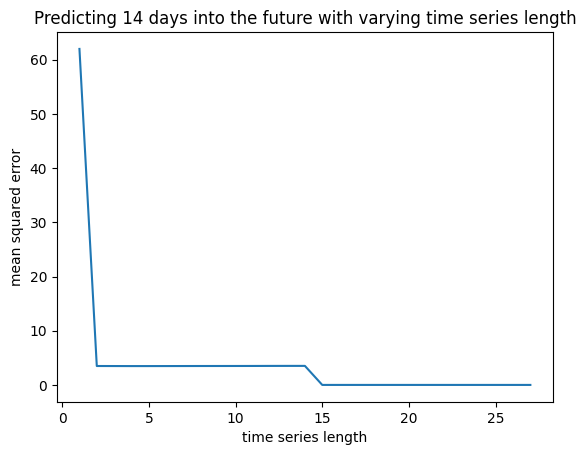

In [72]:
values = []
days = range(1,28)

for i in days:
    mse = gen_model(LinearRegression(normalize=True), dataframe, cols_to_include, time_series_past=i, time_series_future=14)
    values.append(mse)
print("done")
plt.plot(days, values)
print(values)
plt.xlabel("time series length")
plt.ylabel("mean squared error")
plt.title("Predicting 14 days into the future with varying time series length")
plt.show()